This notebook has been designed to strengthen one's understanding of how one numerically constructs a stellar structure by simply using a polytropic equation of state with the appropriate index. 

The cell below sets up the all the functions required that will act as the backbone for this notebook. If you are less computationally inclined, you can simply skip down to the next cell straight into the theoretical introduction

In [6]:
# This block will simply check for any missing python modules and will quietly install them within the Jupyter container.
# No packages will be installed within your actual python directory, so if you have any packages setup in a given way,
# they will not be overwritten
import sys, subprocess,pkg_resources
required = {'numpy','matplotlib','ipython','scipy','tabulate'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

#The necessary libraries are imported here
import tabulate
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Math
from scipy.integrate import odeint
%matplotlib inline 
warnings.filterwarnings("ignore")
def runkutt(y,t,dt,n):
#Runge-Kutta 4th Order integrater as described in 
#An Introduction to Computational Physics, 2nd Edition by Tao Pang    
    c1 = np.zeros(2)
    c2 = np.zeros(2)
    c3 = np.zeros(2)
    c4 = np.zeros(2)
  
    c1 = g(y,t,n)
    
    c2 = y + dt*c1/2
    c2 = g(c2,t+dt/2,n)
    
    c3 = y + dt*c2/2
    c3 = g(c3,t+dt/2,n)
    
    c4 = y + dt*c3/2 
    c4 = g(c4,t+dt/2,n)
    
    return y + dt*(c1 + 2*(c2+c3) +c4)/6

def g(y,t,n):
#generates the vectors that act as the two 1st order differential equations
    v = np.zeros(2)
    
    v[0] = -y[1]/t**2
    v[1] = (y[0]**n)*t**2
    
    return v
def lane_emden_solver(n):
#only takes the polytropic index as input and returns the axis and polytrope
    dt = 20/1000 # the maximum is chosen at 20 to show the roots between n =4 and 5
    y1 = np.zeros(1000)
    y2 = np.zeros(1000)
    y  = np.zeros(2)
    y[0] = 1
    y[1] = 0
    
    y1[0] = y[0]
    y2[0] = y[1]
    t = np.zeros(1000)
    for i in range (1000):
        t[i]  = dt*(i+1)
        y     = runkutt(y,t[i],dt,n)
        y1[i] = y[0]
        y2[i] = y[1]
    return t,y1

def newton_raphson(x,y,dy,x0,i,n):
#Since we don't have an explicit function, we need to interpolate the arrays at every new "root" 
#until the method converges
    if n>=5:
    # since polytropic indices of 5 and beyond admit no roots, we force the output to infinity to
    # avoid any garbage output
        x0 = np.infty
        return x0
    h = y[i]/dy[i]
    while abs(h)>=1e-10:
        x0-=h
        y0 = np.interp(x0,x,y)
        dy0 = np.interp(x0,x,dy)
        h = y0/dy0
    
    return x0
def poly_prop(n,cut_off):
    """this is the main function. It is simply fed the polytropic index and a boolean. The polytropic index
    will determine the polytrope while the cutt_off indicates whether or not you want the solution over the whole axis
    or just up till the root. The method will return all 
    """
    xi,theta = lane_emden_solver(n) #solving the Lane-Emdend differential equation 
                                    #via Runge-Kutta 4th Order
   
    for i in range(len(theta)): #look for the guess for the root solver, which is at the 
                                #index before the 1st negative
        if theta[i]<0:
            break
    d_theta = np.gradient(theta,xi)
    xi_1 = newton_raphson(xi,theta,d_theta,xi[i-1],i,n) #solving for the root 
    
    d_theta_xi_1 = np.interp(xi_1,xi,d_theta) #solving for the derivative at the root
    root_diff_prod = np.power(xi_1,2)*d_theta_xi_1 #xi^2*dtheta/dxi @ xi_1
    if cut_off == True: #the cutoff is used to simulate the star since the values beyong the root
                        # are not required
        xi = xi[0:i-1]
        theta = theta[0:i-1]
        d_theta = d_theta[0:i-1]
    
    return xi,xi_1,theta,d_theta,d_theta_xi_1,root_diff_prod

NameError: name 'warnings' is not defined

In simple terms, the polytropic equation of state is a power-law relation between the pressure (P) and the density $(\rho)$. Algebraically, the relation can be written down as $$P = K\rho^{1+1/n}$$ where n is the polytropic index. The above equation of state is substituted in the equation of hydrostatic equilibrium $$\frac{dP}{dr}=-\frac{GM}{r^{2}}\rho$$ to arrive at the Lane-Emden equation $$\frac{1}{\xi^2}\frac{d}{d\xi}\left(\xi^2\frac{d\theta_n}{d\xi}\right) = -\theta_n^n$$ Full derivation of the Lane-Emden equation is provided [here](https://github.com/jaadt7/Lane_Emden/blob/master/lane_emden_derivation.pdf). The $\theta_n(\xi)$ is known as the Lane-Emden solution of index n, or polytrope of index n. The differential equation has a mixed boundary condition at the center where $$\theta_{n}(0)=1 ; \frac{d\theta_{n}}{d\xi}\Bigr|_{\xi=0}=0$$. Their physical significance reflects the existance of central densities and pressures, and no exchange to a "negative" radius.

Another property of polytropes is that they admit roots for indices between 0 and 5; with 5 exclusive. Since $\xi$ is defined as the dimensionless radius, the axis of the polytrope should only extend to the root since it would be the surface of the star.


To numerically solve the Lane-Emden equation, we split it into 2 first order differential equations:$$\frac{d\theta}{d\xi} = -\frac{\phi}{\xi^2}$$ $$\frac{d\phi}{d\xi}=\theta^n\xi^2$$ and feed it into the solver with the aforementioned boundary conditions. The cell below will do exactly that, outputting a graph over the whole axis, and tabulating certain properties, their importance will be emphasized in subsequent cells

P and $\rho$ are the be calculated by via $P = P_c\theta_n^{n+1}$ and $\rho = \rho_c\theta_n^n$; the subscript is to note the order and the exponent is for the power law. From the forms of the pressure and density, we expect them to have their central values at the stars center and zero at the surface. Hence, the boundary conditions for the Lane-Emden equation are $\theta_n(0) = 1$, $\theta'_n(0) = 0$, and $\theta_n(\xi_1) = 0$, where $\xi_1$ is the (first) root of the polytrope.


<ipython-input-1-e92731755b42>:46: RuntimeWarning: overflow encountered in double_scalars
  v[1] = (y[0]**n)*t**2
/home/jaadt7/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1081: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/jaadt7/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1081: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/jaadt7/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1097: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


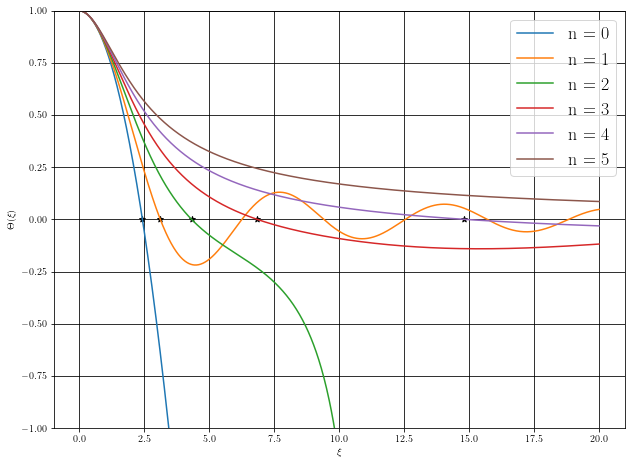

<IPython.core.display.Math object>

0,2.43612,0.816497
1,3.12329,0.31996
2,4.32581,0.128195
3,6.84772,0.0428836
4,14.8213,0.00816061
5,inf,0.00426936


In [7]:
plt.figure(figsize=(10.24,7.68))
cut_off = False #just to show the full form of the polytropes
table = np.empty((6,3))
for n in range(0,6):
    xi,xi_1,theta,d_theta,d_theta_xi_1,root_diff_prod = poly_prop(n, cut_off)
    table[n] = [n,xi_1,-d_theta_xi_1]
    plt.plot(xi,theta,label = 'n = '+str(n))
    plt.scatter(xi_1,0,marker = '*',color = 'black')
    
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\Theta(\xi)$')
plt.ylim([-1,1])
plt.rc('text', usetex=True)
plt.rc('font', family = 'serif')
plt.rcParams['font.size']=18
plt.grid(color = 'black')
plt.legend()
plt.show()
display(Math(r'n  \;\;\;\;\;  \xi_{1}   \;\;\;\;\; -\xi_{1}^{2}\frac{d\theta}{d\xi}\Bigr|_{\xi=\xi_{1}}'))
display(HTML(tabulate.tabulate(table, tablefmt='html')))

The Lane-Emden equation itself admits 3 analytical solutions at indices 0,1, and 5 and have the following forms $$\theta_0(\xi) = 1 - \frac{\xi^2}{6}; \xi_1 = \sqrt6$$ $$\theta_1(\xi) = \frac{sin(\xi)}{\xi}; \xi_1 = \pi$$ $$\theta_5(\xi) = \frac{1}{\sqrt{ \left( 1+\frac{\xi^2}{3} \right)} }; \xi_1 \rightarrow \infty$$
A detailed derivation can be found [here](https://github.com/jaadt7/Lane_Emden/blob/master/analytic_solutions_lane_emden.pdf). By comparing the analytical forms to the above graph, you can see they line up perfectly.

Now let's take what we've studied so far and apply it to a physical proble. We will consider 2 scenarios.

In the first scenario, let's say we wish to determine how well a polytrope of index 3 can describe the profiles in the of a main sequence star. We need to supply the total mass, total radius, and index. For this example, we shall take the sun. We can use the surface properties of the sun(mass and radius) to determine central pressure and density, along with the constant of proportionality K and the scale length. The formulas can be easily derived and are as follows: $$P_c = \frac{8.952e+14}{(n+1)(\theta'_{n})^2_{\xi_1}}\left(\frac{M}{M_\odot}\right)^2\left(\frac{R}{R_\odot}\right)^{-4}dyne.cm^{-2}$$ $$K = \frac{G}{n+1}M^{1-1/n}R^{-1+3/n}\left(\frac{4\pi}{\xi_1^{n+1}(-\theta'_n\Bigr|_{\xi_1})^{n-1}}\right)^{1/n}$$ $$\rho_c = \left(\frac{P_c}{K}\right)^{\frac{n}{n+1}} g/cc$$ $$r_n = \sqrt{\frac{(n+1)P_c}{4\pi G\rho_c^2}}$$

In [5]:
n = 3 #polytropic index
M = 1.0 #total mass in solar masses
R = 1.0#total radius in terms of solar radius

m_sun = 1.989e+33 #grams
r_sun = 6.957e+10 #cm
G = 6.67408e-8    #dyne.(cm/g)^2

#Calculating the polytrope and it's properties
xi = np.linspace(0,20,300)
theta_n = odeint(odes,init_con,xi,(n,))[:,0] #the initial conditions are the same as before
for i in range(len(theta_n)):
    if theta_n[i]<0:
        break
d_theta_n = np.gradient(theta_n,xi) #derivative array
xi_1 = newton_raphson(xi,theta_n,d_theta_n,xi[i-1],i-1,n) #root
d_theta_xi_1 =np.abs(np.interp(xi_1,xi,d_theta_n))# derivative at root

#calculating K
term1 = G/(n+1)
term2 = np.power(M*m_sun,1-1/n)*np.power(R*r_sun,-1+3/n)
term3 = 4*np.pi
term4 = np.power(xi_1,n+1)*np.power(d_theta_xi_1,n-1)
K = term1*term2*np.power(term3/term4,1/n)

#Calculating the central pressure
term1 = 8.952e+14*np.power(M,2)*np.power(R,-4)
term2 = (n+1)*np.power(d_theta_xi_1,2)
P_c   = term1/term2 #dyne/cm^2
#Calculating central density
rho_c = np.power(P_c/K,n/(n+1))
#length scale
term1 = (n+1)*P_c
term2 = 4*np.pi*G*np.power(rho_c,2)
r_n = np.sqrt(term1/term2)


Now that the terms are defined, we simply calculate the pressure and density by $$P = P_c\theta_n^{n+1}$$ $$\rho = \rho_c\theta_n^n$$ The mass can be integrated from the continuity equation $$M(\xi) = 4\pi r_n^3 \rho_c (-\xi^2\theta'_n\Bigr|_\xi)$$ Bear in mind that the subscript 'n' indicates the polytropic index

In [6]:
#since we only need the values up to the root, we need to trim the arrays

theta_n = theta_n[0:i-1]
xi = xi[0:i-1]
d_theta_n = d_theta_n[0:i-1]

P = P_c*np.power(theta_n,n+1)
rho = rho_c*np.power(theta_n,n)
m = -4*np.pi*np.power(r_n,3)*rho_c*np.power(xi,2)*np.interp(xi,xi,d_theta_n)
r  = r_n*xi

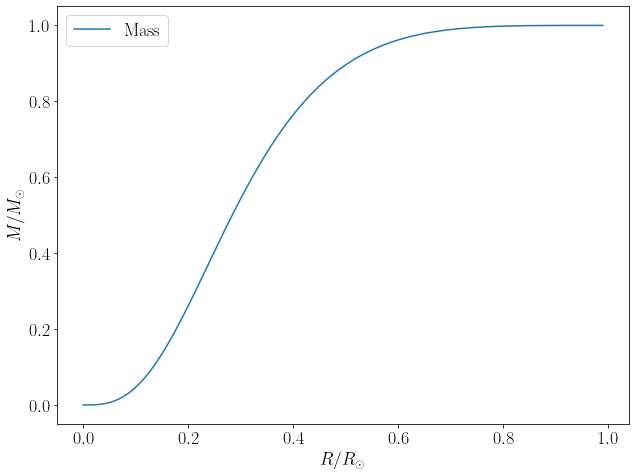

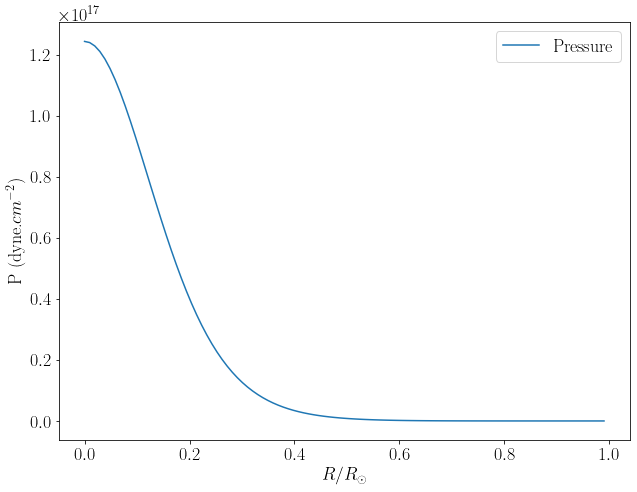

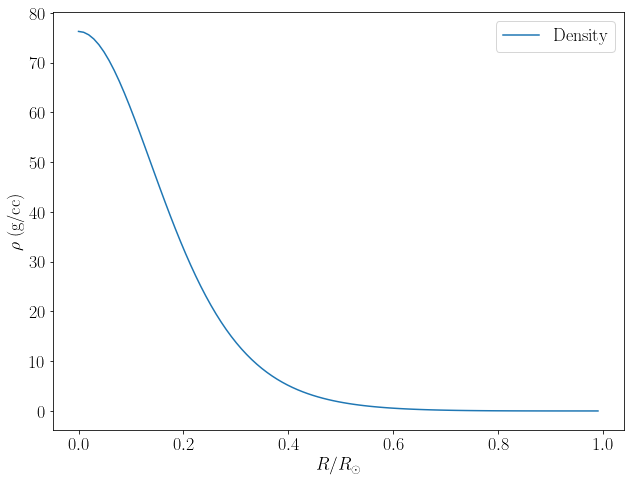

In [7]:
plt.figure(figsize=(10.24,7.68))

plt.plot(r/r_sun,m/m_sun,label='Mass')
plt.xlabel(r'$R/R_{\odot}$')
plt.ylabel(r'$M/M_{\odot}$')
plt.legend()
plt.show()

plt.figure(figsize=(10.24,7.68))
plt.plot(r/r_sun,P,label='Pressure')
plt.xlabel(r'$R/R_{\odot}$')
plt.ylabel(r'P (dyne.$cm^{-2})$')
plt.legend()
plt.show()

plt.figure(figsize=(10.24,7.68))
plt.plot(r/r_sun,rho,label='Density')
plt.ylabel(r'$\rho$ (g/cc)')
plt.xlabel(r'$R/R_{\odot}$')
plt.legend()
plt.show()

Now let's try the problem in a different way. Say we which to determine the properties of a white dwarf of central density $\rho_c = 10^{11} g/cc$, polytropic index 3/2, and K ~ $10^{14}$. We can calculate the total mass and radius of the white dwarf from the properties of the polytrope. The radius is simply $$R = r_n\xi_1$$ and the total mass $$M = -4\pi r_n^3 \rho_c \xi_1^2 \theta'_n\Bigr|_{\xi_1}$$. And from the equation of state itself, we get $$P_c = K\rho_c^{1+1/n}$$

In [8]:
n = 3/2
K = 1e+14
rho_c = 1e+11
#Calculating central pressure
P_c = K*np.power(rho_c,1+1/n)
#length scale
term1 = (n+1)*P_c
term2 = 4*np.pi*G*np.power(rho_c,2)
r_n = np.sqrt(term1/term2)


#Calculating the polytrope and it's properties
xi = np.linspace(0,20,300)
theta_n = odeint(odes,init_con,xi,(n,))[:,0] #the initial conditions are the same as before
for i in range(len(theta_n)):
    if theta_n[i]<0:
        break
d_theta_n = np.gradient(theta_n,xi) #derivative array
xi_1 = newton_raphson(xi,theta_n,d_theta_n,xi[i-1],i-1,n) #root
d_theta_xi_1 =np.abs(np.interp(xi_1,xi,d_theta_n))# derivative at root

theta_n = theta_n[0:i-1]
xi = xi[0:i-1]
d_theta_n = d_theta_n[0:i-1]

P = P_c*np.power(theta_n,n+1)
rho = rho_c*np.power(theta_n,n)
m = -4*np.pi*np.power(r_n,3)*rho_c*np.power(xi,2)*np.interp(xi,xi,d_theta_n)
r  = r_n*xi
#a warning will appear when using fractional indices. This is because the algorithm is trying to take a root of a negative number.
#the algorithm will cut off at the point of inflection

<ipython-input-2-b12578829979>:7: RuntimeWarning: invalid value encountered in power
  v[1] = np.power(y[0],n)*np.power(t,2)#2nd equation


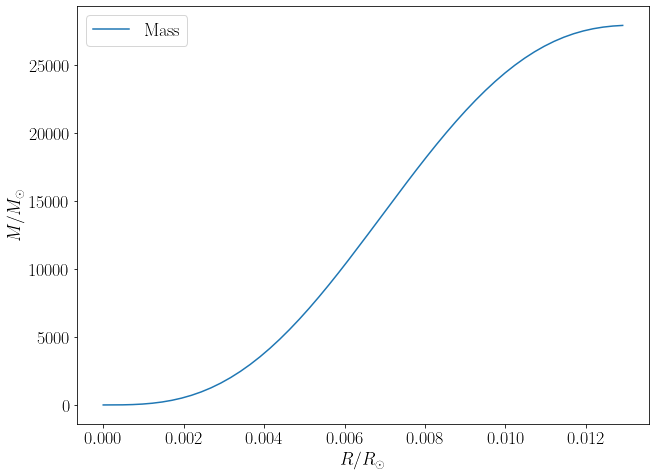

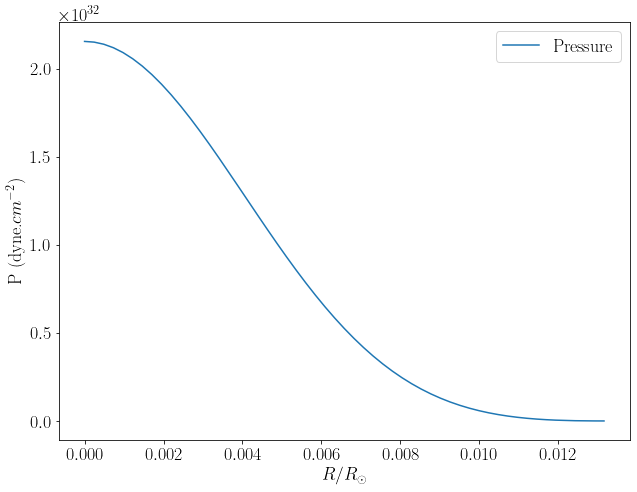

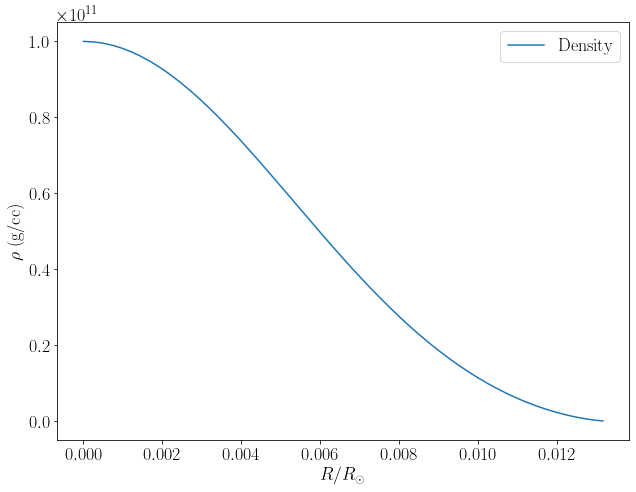

In [9]:
plt.figure(figsize=(10.24,7.68))

plt.plot(r/r_sun,m/m_sun,label='Mass')
plt.xlabel(r'$R/R_{\odot}$')
plt.ylabel(r'$M/M_{\odot}$')
plt.legend()
plt.show()

plt.figure(figsize=(10.24,7.68))
plt.plot(r/r_sun,P,label='Pressure')
plt.xlabel(r'$R/R_{\odot}$')
plt.ylabel(r'P (dyne.$cm^{-2})$')
plt.legend()
plt.show()

plt.figure(figsize=(10.24,7.68))
plt.plot(r/r_sun,rho,label='Density')
plt.ylabel(r'$\rho$ (g/cc)')
plt.xlabel(r'$R/R_{\odot}$')
plt.legend()
plt.show()

Looking at the mass graph, it's obvious we've exceeded the Chandrasekhar limit by a few orders of magnitude. (modeling a black whole structure maybe? (seems far fetched). You go back to the block and see which value of n would give an appropriate distribution (hint: it's an integer less than 5)

If you wish to test around different values for either case, set the appropriate flag to True and supply the values you wish to test. The option to print the data to text file will be available, but commented out if you do not wish to print to file every time you run the block

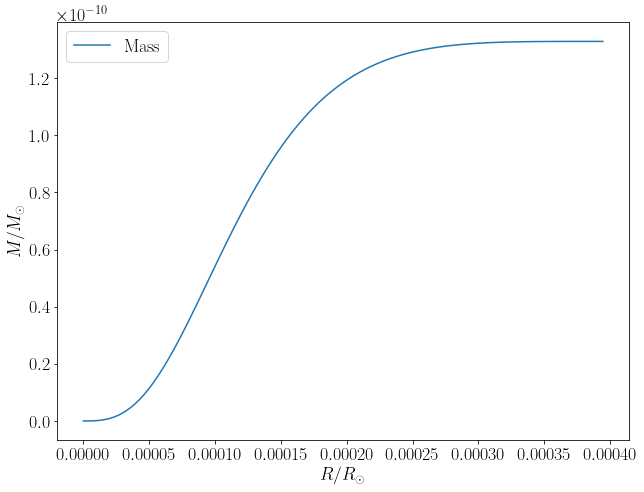

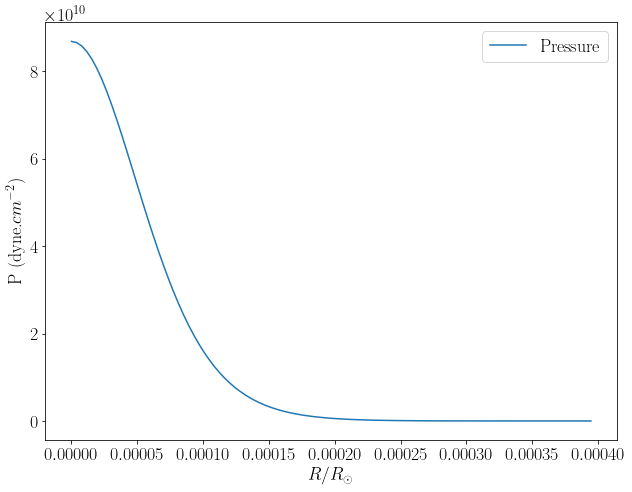

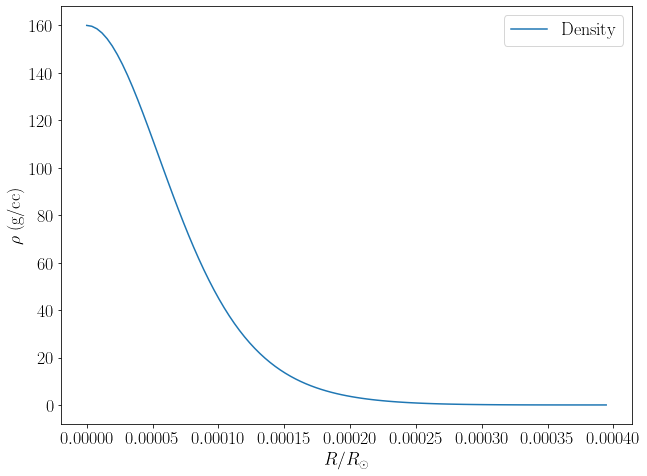

In [10]:
n_K_rho_c = True  #set either marker to true in case you want to supply either the
                  # polytropic index, K and central density, or n, total mass and radius

n     = 3      
K     = 1e+8     
M     = 1.0 #in solar masses
R     = 1.0 #in solar radius
rho_c = 160.0 #in g/cc
# the algorithm will overwrite the appropriate variables depending on the choice you make
if n_K_rho_c:
    #Calculating central pressure
    P_c = K*np.power(rho_c,1+1/n)
    #length scale
    term1 = (n+1)*P_c
    term2 = 4*np.pi*G*np.power(rho_c,2)
    r_n = np.sqrt(term1/term2)


    #Calculating the polytrope and it's properties
    xi = np.linspace(0,20,300)
    theta_n = odeint(odes,init_con,xi,(n,))[:,0] #the initial conditions are the same as before
    for i in range(len(theta_n)):
        if theta_n[i]<0:
            break
    d_theta_n = np.gradient(theta_n,xi) #derivative array
    xi_1 = newton_raphson(xi,theta_n,d_theta_n,xi[i-1],i-1,n) #root
    d_theta_xi_1 =np.abs(np.interp(xi_1,xi,d_theta_n))# derivative at root

    theta_n = theta_n[0:i-1]
    xi = xi[0:i-1]
    d_theta_n = d_theta_n[0:i-1]

    P = P_c*np.power(theta_n,n+1)
    rho = rho_c*np.power(theta_n,n)
    m = -4*np.pi*np.power(r_n,3)*rho_c*np.power(xi,2)*np.interp(xi,xi,d_theta_n)
    r  = r_n*xi
else:
    #Calculating the polytrope and it's properties
    xi = np.linspace(0,20,300)
    theta_n = odeint(odes,init_con,xi,(n,))[:,0] #the initial conditions are the same as before
    for i in range(len(theta_n)):
        if theta_n[i]<0:
            break
    d_theta_n = np.gradient(theta_n,xi) #derivative array
    xi_1 = newton_raphson(xi,theta_n,d_theta_n,xi[i-1],i-1,n) #root
    d_theta_xi_1 =np.abs(np.interp(xi_1,xi,d_theta_n))# derivative at root

    #calculating K
    term1 = G/(n+1)
    term2 = np.power(M*m_sun,1-1/n)*np.power(R*r_sun,-1+3/n)
    term3 = 4*np.pi
    term4 = np.power(xi_1,n+1)*np.power(d_theta_xi_1,n-1)
    K = term1*term2*np.power(term3/term4,1/n)

    #Calculating the central pressure
    term1 = 8.952e+14*np.power(M,2)*np.power(R,-4)
    term2 = (n+1)*np.power(d_theta_xi_1,2)
    P_c   = term1/term2 #dyne/cm^2
    #Calculating central density
    rho_c = np.power(P_c/K,n/(n+1))
    #length scale
    term1 = (n+1)*P_c
    term2 = 4*np.pi*G*np.power(rho_c,2)
    r_n = np.sqrt(term1/term2)

    theta_n = theta_n[0:i-1]
    xi = xi[0:i-1]
    d_theta_n = d_theta_n[0:i-1]

    P = P_c*np.power(theta_n,n+1)
    rho = rho_c*np.power(theta_n,n)
    m = -4*np.pi*np.power(r_n,3)*rho_c*np.power(xi,2)*np.interp(xi,xi,d_theta_n)
    r  = r_n*xi

#graphing    
plt.figure(figsize=(10.24,7.68))

plt.plot(r/r_sun,m/m_sun,label='Mass')
plt.xlabel(r'$R/R_{\odot}$')
plt.ylabel(r'$M/M_{\odot}$')
plt.legend()
plt.show()

plt.figure(figsize=(10.24,7.68))
plt.plot(r/r_sun,P,label='Pressure')
plt.xlabel(r'$R/R_{\odot}$')
plt.ylabel(r'P (dyne.$cm^{-2})$')
plt.legend()
plt.show()

plt.figure(figsize=(10.24,7.68))
plt.plot(r/r_sun,rho,label='Density')
plt.ylabel(r'$\rho$ (g/cc)')
plt.xlabel(r'$R/R_{\odot}$')
plt.legend()
plt.show()

In [11]:
#saving to file. uncomment the lines to save to file
#data = np.column_stack((r,m,P,rho))
#np.savetxt('data.txt',data)